<a href="https://colab.research.google.com/github/elsayeaa/elsayeaa.github.io/blob/master/LUCAS_SCM_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setting up 

from causalgraphicalmodels import CausalGraphicalModel
from causalgraphicalmodels import StructuralCausalModel
import cdt 
import networkx as nx 
import numpy as np
import random as rnd
from sklearn.metrics import mean_squared_error as mse
from sklearn import linear_model
import matplotlib as mpl  
import matplotlib.pyplot as plt
np.random.seed(42) # Random seed for pseudo-random number generating

cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.1.0/bin/Rscript' # Optional depends on your Rscript path.


Detecting 1 CUDA device(s).


In [ ]:
def makeParameters(e = 0):
    
    """
    Given an error term, the function creates random parameters that will be used 
    for building the structual causal model 
    
    0: Lung_Cancer
    1: Smoking
    2: Yellow_Fingers
    3: Anxiety
    4: Peer_Pressure
    5: Genetics
    6: Attention_Disorder
    7: Born_an_Even_Day
    8: Car_Accident
    9: Fatigue
    10: Allergy
    11: Coughing
    """

    randomParameters = {'Lung_Cancer': [rnd.uniform(0,1)+e,rnd.uniform(0,1)+e,rnd.uniform(0,1)+e] ,
                    'Smoking' :[rnd.uniform(0,1)+e,rnd.uniform(0,1)+e,rnd.uniform(0,1)+e], 
                    'Yellow_Fingers' :[rnd.uniform(0,1)+e,rnd.uniform(0,1)+e],
                    'Anxiety' :[rnd.uniform(0,1)+e] ,
                    'Peer_Pressure' :[rnd.uniform(0,1)+e] , 
                    'Genetics' :[rnd.uniform(0,1)+e] , 
                    'Attention_Disorder' :[rnd.uniform(0,1)+e,rnd.uniform(0,1)+e], 
                    'Born_an_Even_Day' :[rnd.uniform(0,1)+e], 
                    'Car_Accident' :[rnd.uniform(0,1)+e,rnd.uniform(0,1)+e,rnd.uniform(0,1)+e], 
                    'Fatigue' :[rnd.uniform(0,1)+e,rnd.uniform(0,1)+e],
                    'Allergy':[rnd.uniform(0,1)+e,rnd.uniform(0,1)+e], 
                    'Coughing':[rnd.uniform(0,1)+e,rnd.uniform(0,1)+e,rnd.uniform(0,1)+e]
                   }
    return randomParameters

In [ ]:
def generateSCM(listofParameters): 
    """
    Given a list of parameters, the function generates a scm graph. 
    """
    scm = StructuralCausalModel({
        'Lung_Cancer': lambda Genetics,Smoking, n_samples: np.random.normal(loc=0, scale=listofParameters['Lung_Cancer'][0], size=n_samples) + listofParameters['Lung_Cancer'][1]*Smoking + listofParameters['Lung_Cancer'][2]*Genetics,
        'Smoking': lambda Anxiety, Peer_Pressure, n_samples: np.random.normal(loc=0, scale=listofParameters['Smoking'][0], size=n_samples) + listofParameters['Smoking'][1]*Anxiety + listofParameters['Smoking'][2]*Peer_Pressure, 
        'Yellow_Fingers': lambda Smoking, n_samples: np.random.normal(loc=0,  scale=listofParameters['Yellow_Fingers'][0],size=n_samples) + listofParameters['Yellow_Fingers'][1]*Smoking,
        'Anxiety': lambda n_samples: np.random.normal(loc=0, scale=listofParameters['Anxiety'][0], size=n_samples), 
        'Peer_Pressure': lambda n_samples: np.random.normal(loc=0, scale=listofParameters['Peer_Pressure'][0], size=n_samples),
        'Genetics': lambda n_samples: np.random.normal(loc=0, scale=listofParameters['Genetics'][0], size=n_samples), 
        'Attention_Disorder': lambda Genetics, n_samples: np.random.normal(loc=0, scale=listofParameters['Attention_Disorder'][0], size=n_samples) + listofParameters['Attention_Disorder'][1]*Genetics, 
        'Born_an_Even_Day': lambda n_samples: np.random.normal(loc=0, scale=listofParameters['Born_an_Even_Day'][0], size=n_samples),
        'Car_Accident': lambda Attention_Disorder, Fatigue, n_samples: np.random.normal(loc=0, scale=listofParameters['Car_Accident'][0], size=n_samples) + listofParameters['Car_Accident'][1]*Attention_Disorder + listofParameters['Car_Accident'][2]*Fatigue,
        'Fatigue': lambda Lung_Cancer, n_samples: np.random.normal(loc=0, scale=listofParameters['Fatigue'][0], size=n_samples) + listofParameters['Fatigue'][1]*Lung_Cancer,
        'Allergy': lambda n_samples: np.random.normal(loc=0, scale=listofParameters['Allergy'][0],size=n_samples), 
        'Coughing': lambda Lung_Cancer, Allergy, n_samples: np.random.normal(loc=0, scale=listofParameters['Coughing'][0], size=n_samples)+ listofParameters['Coughing'][1]*Lung_Cancer + listofParameters['Coughing'][2] * Allergy
    })
    scm.cgm.draw()
    return scm 

In [ ]:
def modifyParams(SourceParameters, RVs, parameters): 
    for RV, param in zip(RVs, parameters):
        SourceParameters[RV] = param 
    scm = generateSCM(SourceParameters)
    return scm

In [ ]:
def generateDataset(scm, n): 
    """
    Given an scm and a number of samples, we generate a dataset  
    """
    dataset = scm.sample(n_samples = n)
    return dataset

In [ ]:
def getCausalDiscoveryGraph(dataset, algorithm): 
    model = eval(f"cdt.causality.graph.{algorithm}()")
    output_graph = model.predict(dataset)
    
    return output_graph

In [ ]:
def ExtractParentsAndChildren(graph, target): 
    # Actual input 
    parents = list(graph.predecessors(target))
    children = list(graph.successors(target))
    # Dummy input 
    dummyParents, dummyChildren = ['Smoking', 'Genetics'], ['Fatigue', 'Coughing']
    return dummyParents, dummyChildren


In [ ]:
def GenerateMultipleDatasets(ds_initial, params, causal_cols, anticausal_cols, target, n=8, variation='causal'): 
    causal, anticausal =  variation=='causal', variation=='anticausal'
    # Varying Parents -- causal 
    if causal: 
        ds_initial = ds_initial[causal_cols+target]
        for i in range(n): 
            RV = rnd.choice(causal_cols)
            modified_parameters = [rnd.uniform(1,2) for j in range(len(params[RV]))]
            scm_modified = modifyParams(params, RV, modified_parameters)
            ds_other = generateDataset(scm_modified, 1000)[causal_cols + target]
            ds_initial = ds_initial.append(ds_other, ignore_index=True)            
    # Varying children -- anticausal    
    elif anticausal: 
        ds_initial = ds_initial[causal_cols+anticausal_cols+target]
        for i in range(n): 
            RV = rnd.choice(anticausal_cols)
            modified_parameters = [rnd.uniform(1,2) for j in range(len(params[RV]))]
            scm_modified = modifyParams(params, RV, modified_parameters)
            ds_other = generateDataset(scm_modified, 1000)[anticausal_cols + causal_cols + target]
            ds_initial = ds_initial.append(ds_other, ignore_index=True) 

    ds = ds_initial     
    return ds

In [ ]:
def learn_model(ds_source, target, inputs=None): 
    X_s, y = ds_source[inputs].to_numpy(), ds_source[target].to_numpy()
    model = linear_model.LinearRegression().fit(X_s, y)
    return model

In [ ]:
def evaluate_error(model, Y, X): 
    coeff = model.coef_[0,:] 
    X_ = np.zeros(Y.shape)
    for i in range(len(coeff)): 
        X_ += coeff[i] * X[:,i].reshape(Y.shape)
    return mse(Y, X_)
   

In [ ]:
# Generating Source Data
def create_error_arrays(E, e):
    causal_errors_array = np.array([0])
    anticausal_errors_array = np.array([0])
    for k in range(E):
        sourceParameters = makeParameters(e = 0)
        scm_source = generateSCM(sourceParameters)
        ds_source_initial = generateDataset(scm_source, 1000)

        # Running a discovery algorithm tool 
        graph = getCausalDiscoveryGraph(ds_source_initial, 'PC')
        target = 'Lung_Cancer'
        causal_cols, anticausal_cols = ExtractParentsAndChildren(graph, target)

        # anticausal_cols = [x for x in anticausal_cols if (x in anticausal_cols and x not in causal_cols) ]

        n = rnd.randrange(8,25)
        target = [target]
        # Making Datasets 
        ds_source_causal = GenerateMultipleDatasets(ds_source_initial, sourceParameters, causal_cols, anticausal_cols, target, n=n, variation='causal')
        ds_source_anticausal = GenerateMultipleDatasets(ds_source_initial, sourceParameters, causal_cols, anticausal_cols, target, n=n, variation='anticausal')
        ds_size = ds_source_causal.shape[0]




        # Making Transfer Data 

        transferParameters = makeParameters(e = e)
        scm_transfer = generateSCM(transferParameters)
        ds_transfer = generateDataset(scm_transfer, ds_size)
#         if k == 0: 
#             print(f""" Data Frames:-
#             1) Main: 
#             {ds_source_initial}
#             2) Parents:
#             {ds_source_causal}
#             3) Children and Parents:
#             {ds_source_anticausal}
#             4) Transfer Dataset: 
#             {ds_transfer}
#             """)

        # Learn Models
        causal_model = learn_model(ds_source_causal,target, inputs = causal_cols)
        anticausal_model = learn_model(ds_source_anticausal, target, inputs = causal_cols + anticausal_cols)

        # Prepare Transfer 

        Y = ds_transfer[target].to_numpy().reshape(-1,1)
        X_1 = ds_transfer[causal_cols].to_numpy()
        X_2 = ds_transfer[causal_cols+anticausal_cols].to_numpy()

        # Evaluating Errors 

        causal_error, anticausal_error =  [evaluate_error(causal_model, Y, X_1)], [evaluate_error(anticausal_model, Y, X_2)]
        causal_errors_array = np.append(causal_errors_array, causal_error)
        anticausal_errors_array = np.append(anticausal_errors_array, anticausal_error)
        
        return causal_errors_array, anticausal_errors_array

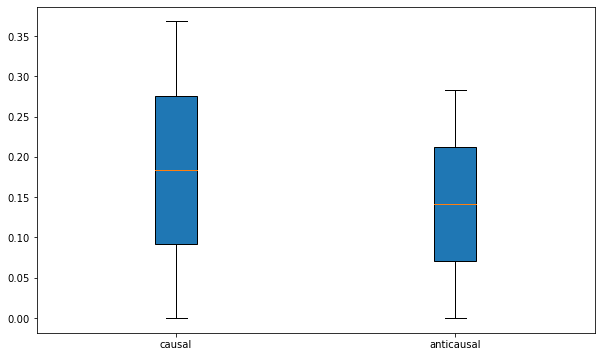

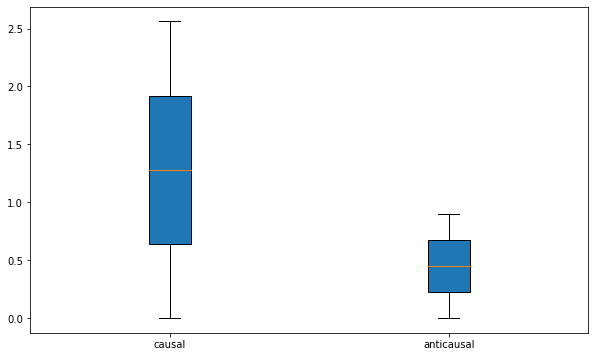

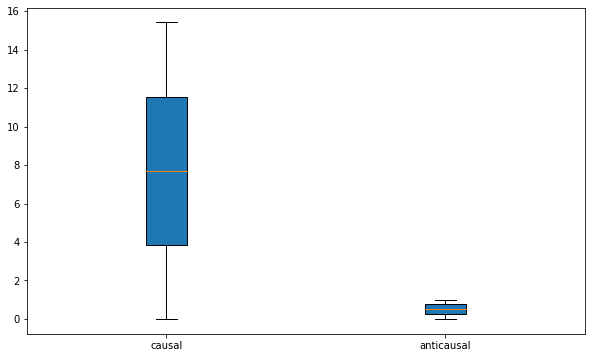

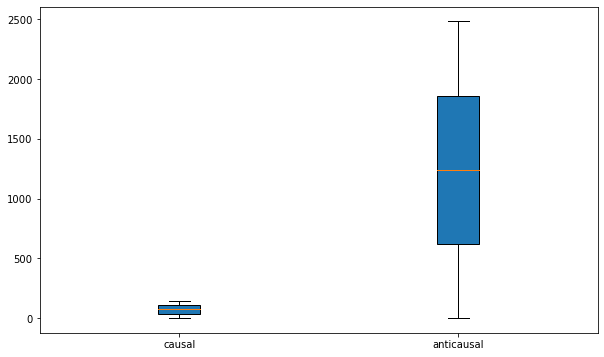

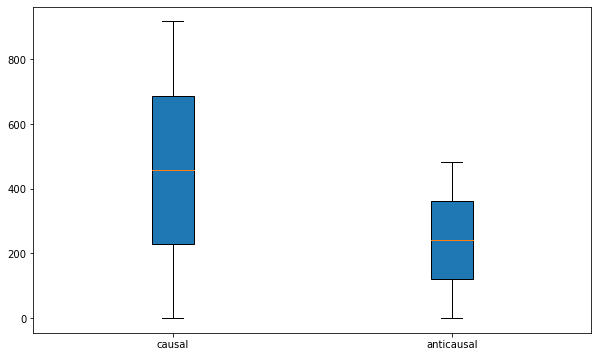

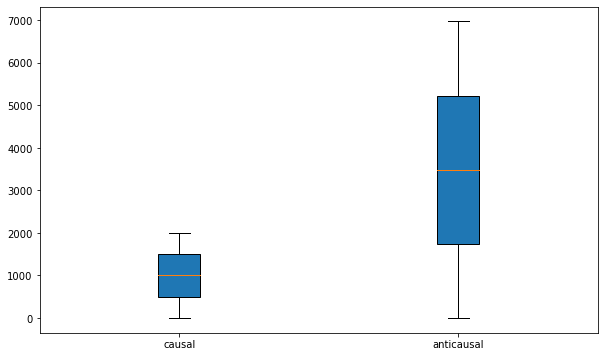

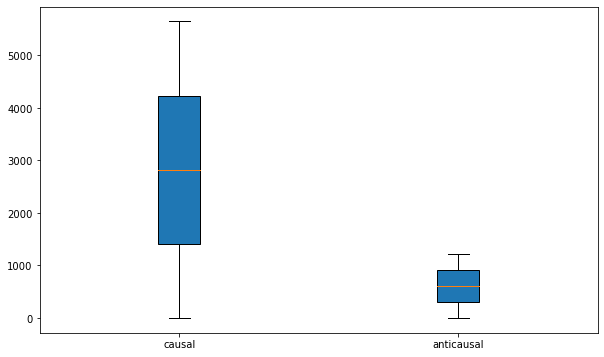

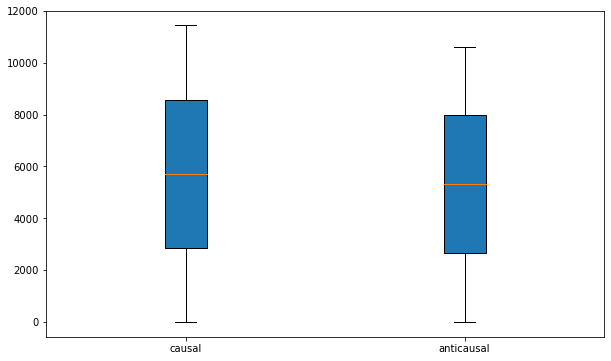

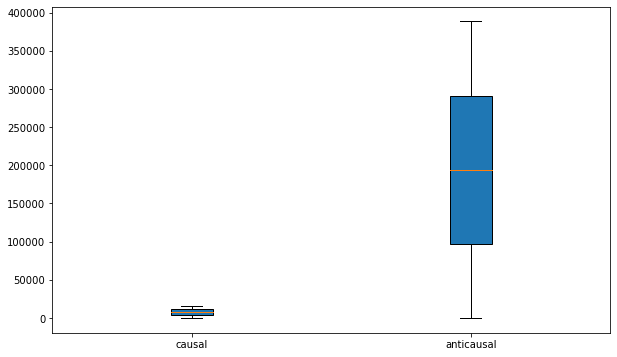

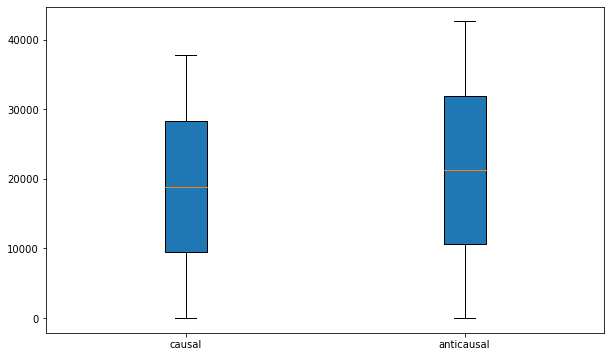

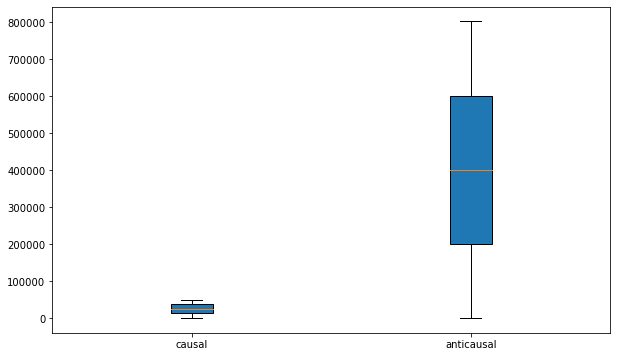

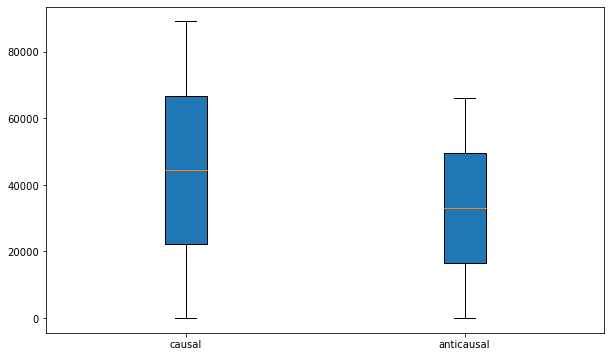

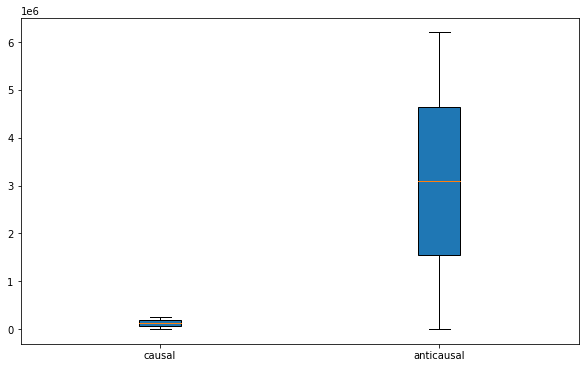

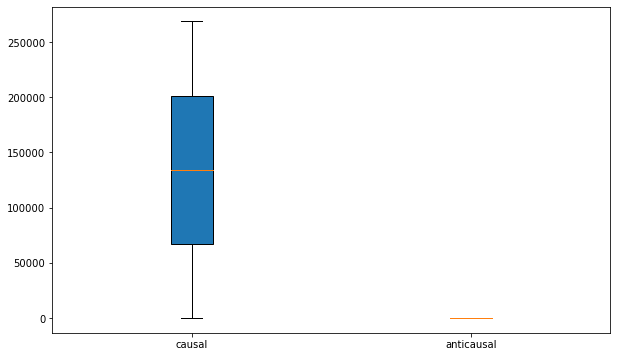

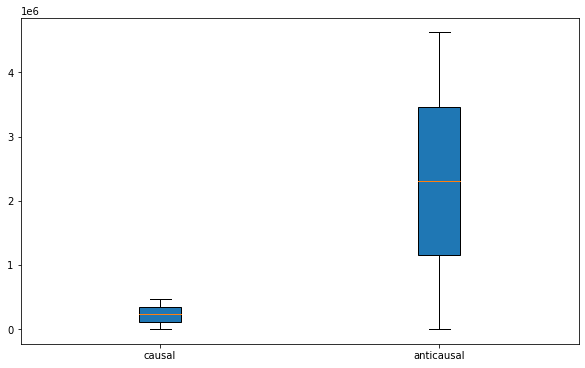

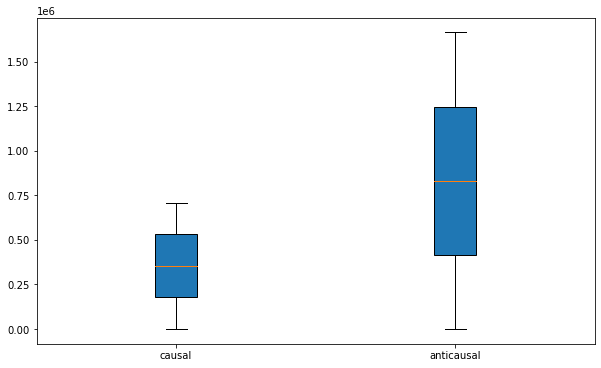

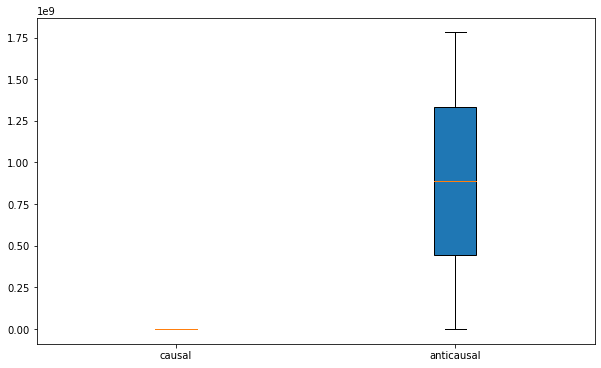

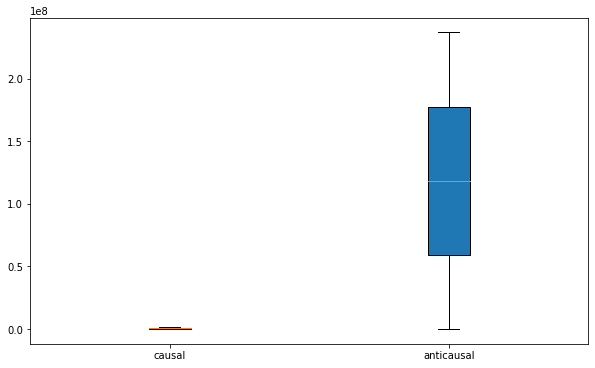

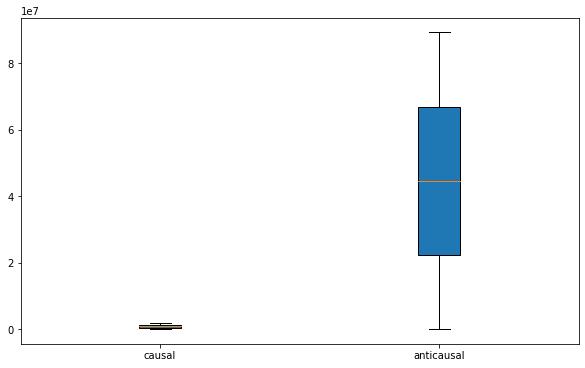

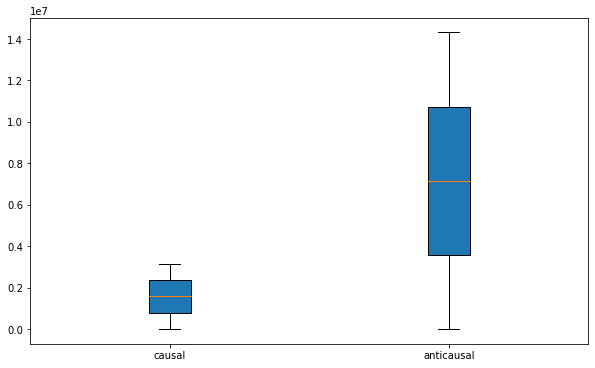

In [ ]:
errorValues = np.linspace(0, 10, 20)
for i in range(20):
    data_to_plot = create_error_arrays(1000, errorValues[i])
    fig = plt.figure(figsize=(10,6))
    fig.canvas.set_window_title('Causal Vs. Anticausal')
    ax  = fig.add_subplot(111)
    bp  = ax.boxplot(data_to_plot, labels = ['causal', 'anticausal'], patch_artist=True) 
    plt.show()
